In [140]:
import pandas as pd 
import numpy as np
import pickle
from msresist.pre_processing import MeanCenter, Log2T
from msresist.validations import pos_to_motif
from msresist.clustering import MassSpecClustering
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.figures.figure1 import plotPCA
from msresist.figures.figure2 import plotDistanceToUpstreamKinase, plotR2YQ2Y, plotScoresLoadings
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression

In [2]:
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
X = pd.read_csv("msresist/data/MS/KRAS_G12C_Haura.csv")
X = MeanCenter(X, mc_row=True, mc_col=False)
X.insert(1, "Positions", [(aa + pos).split(";")[0] for aa, pos in zip(X["Amino Acid"], X["Positions Within Proteins"])])
X = X.drop(["Amino Acid", "Positions Within Proteins"], axis=1)
motifs, del_ids = pos_to_motif(X["Gene"], X["Positions"])
X = X.set_index(["Gene", "Positions"]).drop(del_ids).reset_index()
X.insert(0, "Sequence", motifs)
d = X.select_dtypes(include=[float]).T
i = X.select_dtypes(include=[object])

In [4]:
with open('msresist/data/pickled_models/KRAS_Haura_Binomial_CL15_W10', 'rb') as m:    
    model = pickle.load(m)

In [43]:
centers = pd.DataFrame(model.transform()).T
centers.columns = d.index
centers.index = np.arange(model.ncl) + 1

cols = centers.columns
centers = centers.T
centers["Cell Line"] = [i.split("_")[0] for i in cols]
centers["Time point"] = [i.split("_")[1] for i in cols]

No handles with labels found to put in legend.


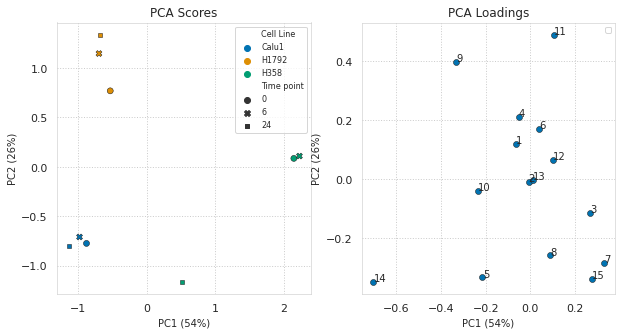

In [51]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

plotPCA(ax, centers.reset_index(), 2, ["Cell Line", "Time point"], "Cluster", hue_scores="Cell Line", style_scores="Time point")

No handles with labels found to put in legend.


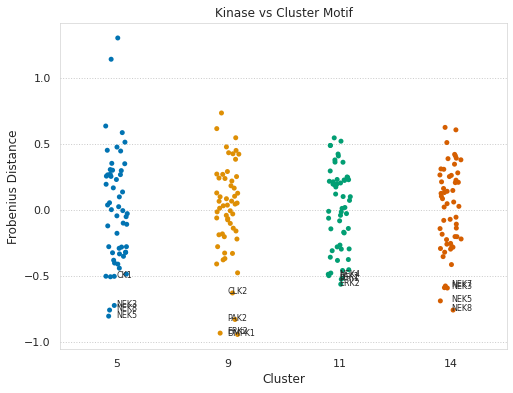

In [53]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
plotDistanceToUpstreamKinase(model, [5, 9, 11, 14], ax, num_hits=4)

### Fit only time point 24h

In [4]:
d24h = d.iloc[[2, 5, 8], :]

In [160]:
model24h = MassSpecClustering(i, 10, 5, "Binomial").fit(d24h, nRepeats=0)

In [161]:
centers24h = pd.DataFrame(model24h.transform()).T
centers24h.columns = d24h.index
centers24h.index = np.arange(model24h.ncl) + 1

In [162]:
cv = pd.DataFrame()
cv["Viability"] = [74.53541102, 100.9963665, 27.18697698]
cv.index = centers24h.columns
cv["Viability"] = zscore(cv)

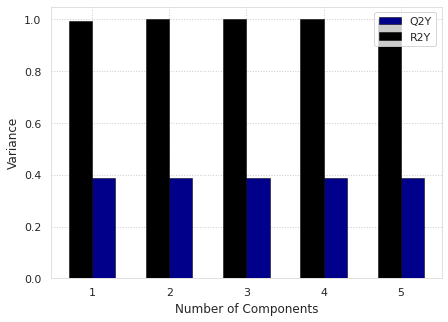

In [163]:
plsr = PLSRegression(n_components=3, scale=False)

_, ax = plt.subplots(1, 1, figsize=(7, 5))
plotR2YQ2Y(ax, plsr, centers24h.T, cv, b=6, color="darkblue", title=False)

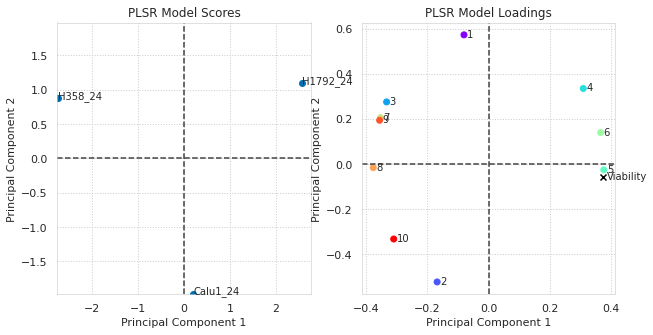

In [109]:
plsr = PLSRegression(n_components=2)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotScoresLoadings(ax, plsr.fit(centers24h.T, cv), centers24h.T, cv, model24h.ncl, centers24h.columns, pcX=1, pcY=2, spacer=0.01)